In [1]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator

# SDXL unCLIP requires code from https://github.com/Stability-AI/generative-models/tree/main
import sgm
from sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder, FrozenOpenCLIPEmbedder2
from sgm.models.diffusion import DiffusionEngine
from sgm.util import append_dims
from omegaconf import OmegaConf

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import src.utils as utils
from src.models import *

import lovely_tensors as lt
lt.monkey_patch()

from csng.data import get_dataloaders
from csng.utils.mix import seed_all

DATA_PATH_BRAINREADER = os.path.join(os.environ["DATA_PATH"], "brainreader")
DATA_PATH_MINDEYE = os.path.join(os.environ["DATA_PATH"], "mindeye")
DATA_PATH_MINDEYE_CACHE = os.path.join(DATA_PATH_MINDEYE, "cache")
print(f"{DATA_PATH_BRAINREADER=}\n{DATA_PATH_MINDEYE=}\n{DATA_PATH_MINDEYE_CACHE=}")

# accelerator = Accelerator(split_batches=False, mixed_precision="fp16")
# device = accelerator.device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:",device)

!nvidia-smi

/home/sobotka/miniconda3/envs/mindeye/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


DATA_PATH_BRAINREADER='/scratch/izar/sobotka/csng/brainreader'
DATA_PATH_MINDEYE='/scratch/izar/sobotka/csng/mindeye'
DATA_PATH_MINDEYE_CACHE='/scratch/izar/sobotka/csng/mindeye/cache'
device: cuda
Sat Feb 15 10:32:27 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB           On  | 00000000:D8:00.0 Off |                  Off |
| N/A   32C    P0              24W / 250W |      0

## Configuration

In [2]:
model_name = "csng_14-02-25_23-59"
cache_dir = DATA_PATH_MINDEYE_CACHE
data_path = DATA_PATH_BRAINREADER
outdir = f'{DATA_PATH_MINDEYE}/train_logs/{model_name}'
evals_dir = f'{DATA_PATH_MINDEYE}/evals/{model_name}'
assert os.path.exists(outdir)
os.makedirs(evals_dir, exist_ok=True)

In [3]:
# Load pretrained model ckpt
tag = 'last'
print(f"\n---loading {outdir}/{tag}.pth ckpt---\n")
checkpoint = torch.load(outdir+f'/{tag}.pth', map_location='cpu')
state_dict = checkpoint['model_state_dict']
cfg = checkpoint['cfg']
cfg["model"]["evals_dir"] = evals_dir
cfg


---loading /scratch/izar/sobotka/csng/mindeye/train_logs/csng_14-02-25_23-59/last.pth ckpt---



{'device': 'cuda',
 'data_type': torch.float16,
 'seed': 0,
 'data': {'mixing_strategy': 'parallel_min',
  'max_training_batches': None,
  'brainreader_mouse': {'device': 'cuda',
   'mixing_strategy': 'parallel_min',
   'max_batches': None,
   'data_dir': '/scratch/izar/sobotka/csng/brainreader/data',
   'batch_size': 8,
   'sessions': [6],
   'resize_stim_to': (36, 64),
   'normalize_stim': True,
   'normalize_resp': True,
   'div_resp_by_std': True,
   'clamp_neg_resp': False,
   'additional_keys': None,
   'avg_test_resp': True,
   'drop_last': True},
  'num_samples_per_epoch': 4496,
  'num_iterations_per_epoch': 562},
 'wandb': {'project': 'MindEye', 'group': 'mindeye'},
 'model': {'model_name': 'csng_14-02-25_23-59',
  'cache_dir': '/scratch/izar/sobotka/csng/mindeye/cache',
  'data_path': '/scratch/izar/sobotka/csng/brainreader',
  'outdir': '/scratch/izar/sobotka/csng/mindeye/train_logs/csng_14-02-25_23-59',
  'ckpt_saving': True,
  'ckpt_interval': 1,
  'subj_list': [6],
  'num

## Data

In [4]:
seed_all(cfg["seed"])
dls, _ = get_dataloaders(config=cfg)
assert len(dls["test"]["brainreader_mouse"].dataloaders) == 1, "Only one dataloader supported for now"
test_dl = dls["test"]["brainreader_mouse"].dataloaders[0]
data_key = dls["test"]["brainreader_mouse"].data_keys[0]

voxels = {f'subj0{data_key}': []}
images = []
for b_i, batch in enumerate(test_dl):
    images.append(batch.images.cpu())
    voxels[f'subj0{data_key}'].append(batch.responses.cpu())
images = torch.cat(images, dim=0)
voxels = {k: torch.cat(v, dim=0) for k,v in voxels.items()}
print(f"{images=}\n{voxels['subj0'+data_key]=}")

images=tensor[40, 1, 36, 64] n=92160 (0.4Mb) x∈[-2.333, 2.915] μ=-0.318 σ=1.528
voxels['subj0'+data_key]=tensor[40, 8587] n=343480 (1.3Mb) x∈[-0.901, 18.082] μ=0.000 σ=0.510


In [5]:
clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    arch=cfg["model"]["clip_img_embedder_arch"],
    version=cfg["model"]["clip_img_embedder_version"],
    output_tokens=True,
    only_tokens=True,
    cache_dir=cfg["model"]["cache_dir"],
)
clip_img_embedder.to(cfg["device"])

FrozenOpenCLIPImageEmbedder(
  (model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 1664, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (patch_dropout): Identity()
      (ln_pre): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): ModuleList(
          (0-47): 48 x ResidualAttentionBlock(
            (ln_1): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=1664, out_features=1664, bias=True)
            )
            (ls_1): Identity()
            (ln_2): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=1664, out_features=8192, bias=True)
              (gelu): GELU(approximate='none')
              (c_proj): Linear(in_features=8192, out_features=1664, bias=True)
            )
            (ls_2): Identity()


In [6]:
if cfg["model"]["blurry_recon"]:
    from diffusers import AutoencoderKL
    autoenc = AutoencoderKL(**cfg["model"]["autoenc"])
    ckpt = torch.load(f'{cfg["model"]["cache_dir"]}/sd_image_var_autoenc.pth')
    autoenc.load_state_dict(ckpt)
    autoenc.eval()
    autoenc.requires_grad_(False)
    autoenc.to(cfg["device"])
    utils.count_params(autoenc)

param counts:
83,653,863 total
0 trainable


In [7]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    
    def forward(self, x):
        return x
        
class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer to enable regularization
    def __init__(self, input_sizes, out_features): 
        super(RidgeRegression, self).__init__()
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
                torch.nn.Linear(input_size, out_features) for input_size in input_sizes
            ])
    
    def forward(self, x, subj_idx):
        out = self.linears[subj_idx](x[:,0]).unsqueeze(1)
        return out

model = MindEyeModule()
model.ridge = RidgeRegression(cfg["model"]["num_voxels_list"], out_features=cfg["model"]["hidden_dim"])

In [8]:
from src.models import BrainNetwork

model.backbone = BrainNetwork(**cfg["model"]["brainnetwork"]) 
utils.count_params(model.ridge)
utils.count_params(model.backbone)
utils.count_params(model)

# setup diffusion prior network
prior_network = PriorNetwork(**cfg["model"]["prior_network"])

model.diffusion_prior = BrainDiffusionPrior(net=prior_network, **cfg["model"]["brain_diffusion_prior"])
model.to(cfg["device"])

utils.count_params(model.diffusion_prior)
utils.count_params(model)

param counts:
8,794,112 total
8,794,112 trainable
param counts:
458,885,116 total
458,885,116 trainable
param counts:
467,679,228 total
467,679,228 trainable
param counts:
259,865,216 total
259,865,200 trainable
param counts:
727,544,444 total
727,544,428 trainable


727544428

In [9]:
# Load pretrained model ckpt
model.load_state_dict(checkpoint['model_state_dict'], strict=True)
del checkpoint

In [10]:
# setup text caption networks
from transformers import AutoProcessor, AutoModelForCausalLM
from src.modeling_git import GitForCausalLMClipEmb

processor = AutoProcessor.from_pretrained("microsoft/git-large-coco")
clip_text_model = GitForCausalLMClipEmb.from_pretrained("microsoft/git-large-coco")
# clip_text_model.to(device) # if you get OOM running this script, you can switch this to cpu and lower minibatch_size to 4
clip_text_model.to("cpu") # if you get OOM running this script, you can switch this to cpu and lower minibatch_size to 4
clip_text_model.eval().requires_grad_(False)
cfg["model"]["clip_text_seq_dim"] = 257
cfg["model"]["clip_text_emb_dim"] = 1024

class CLIPConverter(torch.nn.Module):
    def __init__(self):
        super(CLIPConverter, self).__init__()
        self.linear1 = nn.Linear(cfg["model"]["clip_seq_dim"], cfg["model"]["clip_text_seq_dim"])
        self.linear2 = nn.Linear(cfg["model"]["clip_emb_dim"], cfg["model"]["clip_text_emb_dim"])

    def forward(self, x):
        x = x.permute(0,2,1)
        x = self.linear1(x)
        x = self.linear2(x.permute(0,2,1))
        return x
        
clip_convert = CLIPConverter()
state_dict = torch.load(f"{cfg['model']['cache_dir']}/bigG_to_L_epoch8.pth", map_location='cpu')['model_state_dict']
clip_convert.load_state_dict(state_dict, strict=True)
# clip_convert.to(device) # if you get OOM running this script, you can switch this to cpu and lower minibatch_size to 4
clip_convert.to("cpu") # if you get OOM running this script, you can switch this to cpu and lower minibatch_size to 4
del state_dict

/home/sobotka/miniconda3/envs/mindeye/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
# prep unCLIP
from omegaconf import OmegaConf
from copy import deepcopy

config = OmegaConf.load("src/generative_models/configs/unclip6.yaml")
config = OmegaConf.to_container(config, resolve=True)
cfg["model"]["unclip"] = deepcopy(config)
unclip_params = config["model"]["params"]
network_config = unclip_params["network_config"]
denoiser_config = unclip_params["denoiser_config"]
first_stage_config = unclip_params["first_stage_config"]
conditioner_config = unclip_params["conditioner_config"]
sampler_config = unclip_params["sampler_config"]
scale_factor = unclip_params["scale_factor"]
disable_first_stage_autocast = unclip_params["disable_first_stage_autocast"]
offset_noise_level = unclip_params["loss_fn_config"]["params"]["offset_noise_level"]

first_stage_config['target'] = 'sgm.models.autoencoder.AutoencoderKL'
sampler_config['params']['num_steps'] = 38

diffusion_engine = DiffusionEngine(
    network_config=network_config,
    denoiser_config=denoiser_config,
    first_stage_config=first_stage_config,
    conditioner_config=conditioner_config,
    sampler_config=sampler_config,
    scale_factor=scale_factor,
    disable_first_stage_autocast=disable_first_stage_autocast
)
# set to inference
diffusion_engine.eval().requires_grad_(False)
diffusion_engine.to(cfg["device"])

ckpt_path = f'{cfg["model"]["cache_dir"]}/unclip6_epoch0_step110000.ckpt'
ckpt = torch.load(ckpt_path, map_location='cpu')
diffusion_engine.load_state_dict(ckpt['state_dict'])

batch={"jpg": torch.randn(1,3,1,1).to(cfg["device"]), # jpg doesnt get used, it's just a placeholder
      "original_size_as_tuple": torch.ones(1, 2).to(cfg["device"]) * 768,
      "crop_coords_top_left": torch.zeros(1, 2).to(cfg["device"])}
out = diffusion_engine.conditioner(batch)
vector_suffix = out["vector"].to(cfg["device"])
print("vector_suffix", vector_suffix.shape)

Initialized embedder #0: FrozenOpenCLIPImageEmbedder with 1909889025 params. Trainable: False
Initialized embedder #1: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #2: ConcatTimestepEmbedderND with 0 params. Trainable: False
vector_suffix torch.Size([1, 1024])


  0%|                                               | 0/40 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person standing in front of a camera.']


/home/sobotka/miniconda3/envs/mindeye/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/sobotka/miniconda3/envs/mindeye/lib/python3.11/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


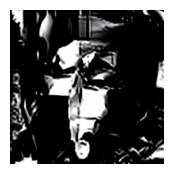

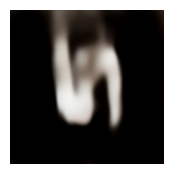

  2%|▉                                      | 1/40 [00:12<08:10, 12.57s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man is standing in front of a building.']


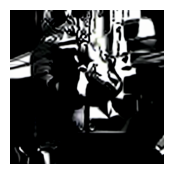

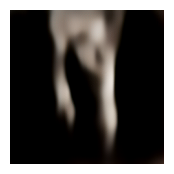

  5%|█▉                                     | 2/40 [00:24<07:46, 12.28s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man is holding a camera.']


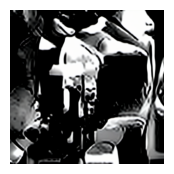

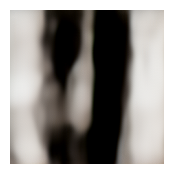

  8%|██▉                                    | 3/40 [00:36<07:19, 11.89s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person standing in front of a building.']


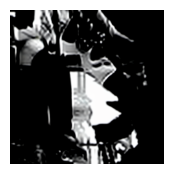

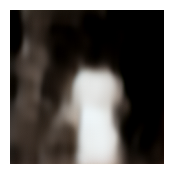

 10%|███▉                                   | 4/40 [00:47<07:07, 11.87s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man standing in front of a building.']


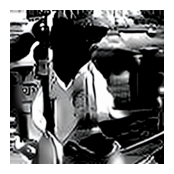

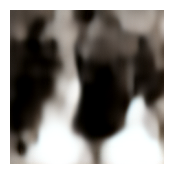

 12%|████▉                                  | 5/40 [00:59<06:56, 11.90s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a picture of a person.']


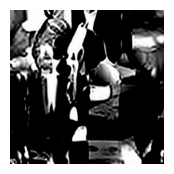

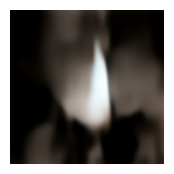

 15%|█████▊                                 | 6/40 [01:11<06:36, 11.65s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person is standing in front of a building.']


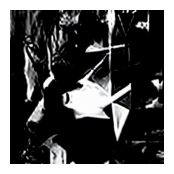

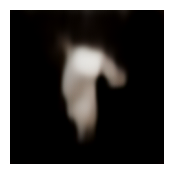

 18%|██████▊                                | 7/40 [01:23<06:29, 11.80s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person is standing up.']


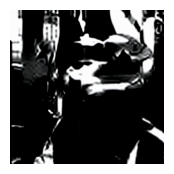

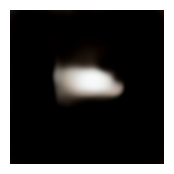

 20%|███████▊                               | 8/40 [01:34<06:11, 11.60s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a picture of a person.']


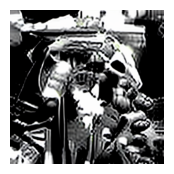

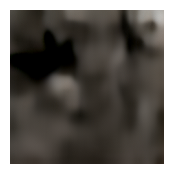

 22%|████████▊                              | 9/40 [01:45<05:55, 11.47s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person standing in front of a building.']


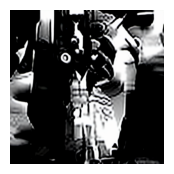

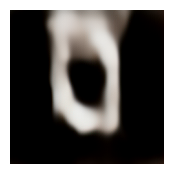

 25%|█████████▌                            | 10/40 [01:57<05:47, 11.60s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person standing in front of a camera.']


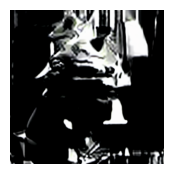

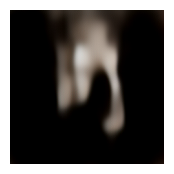

 28%|██████████▍                           | 11/40 [02:09<05:39, 11.69s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man standing in front of a building.']


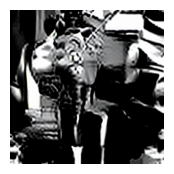

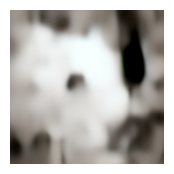

 30%|███████████▍                          | 12/40 [02:21<05:29, 11.76s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person that is standing up.']


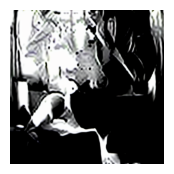

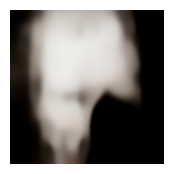

 32%|████████████▎                         | 13/40 [02:32<05:14, 11.66s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a large black and white image of a person.']


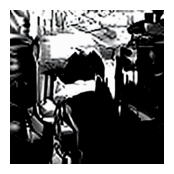

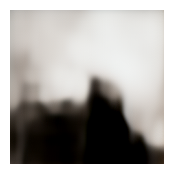

 35%|█████████████▎                        | 14/40 [02:44<05:07, 11.81s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a black and white photo of a person.']


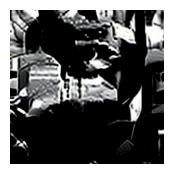

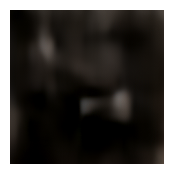

 38%|██████████████▎                       | 15/40 [02:56<04:56, 11.85s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a picture of a person.']


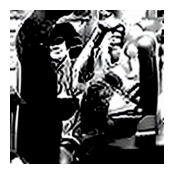

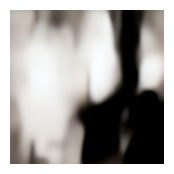

 40%|███████████████▏                      | 16/40 [03:07<04:39, 11.65s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a picture of a person.']


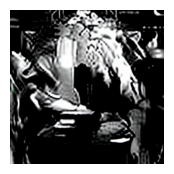

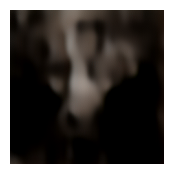

 42%|████████████████▏                     | 17/40 [03:19<04:24, 11.52s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a man standing in front of a building.']


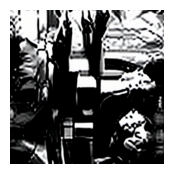

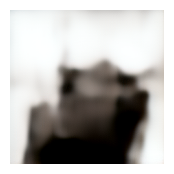

 45%|█████████████████                     | 18/40 [03:31<04:16, 11.65s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person standing in front of a camera.']


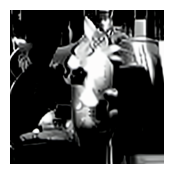

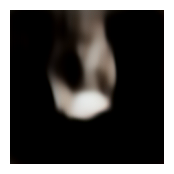

 48%|██████████████████                    | 19/40 [03:43<04:06, 11.74s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a picture of a person.']


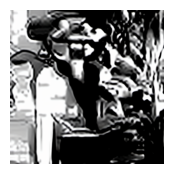

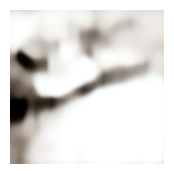

 50%|███████████████████                   | 20/40 [03:54<03:51, 11.58s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a picture of a person.']


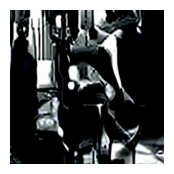

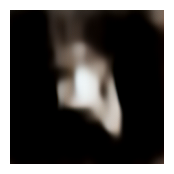

 52%|███████████████████▉                  | 21/40 [04:05<03:37, 11.47s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a picture of a person.']


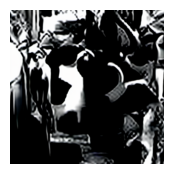

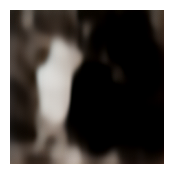

 55%|████████████████████▉                 | 22/40 [04:16<03:25, 11.39s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a large white and black object.']


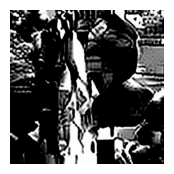

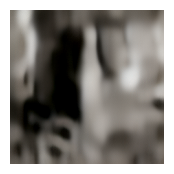

 57%|█████████████████████▊                | 23/40 [04:28<03:13, 11.41s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a picture of a person.']


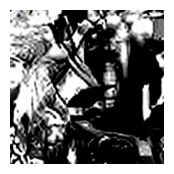

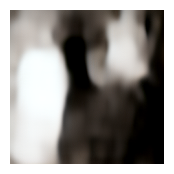

 60%|██████████████████████▊               | 24/40 [04:39<03:01, 11.36s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a picture of a person.']


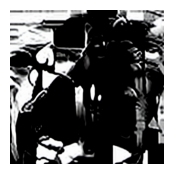

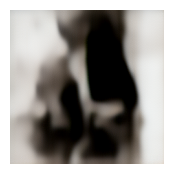

 62%|███████████████████████▊              | 25/40 [04:50<02:49, 11.32s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a large black and white image of a person.']


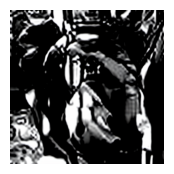

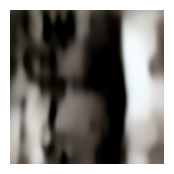

 65%|████████████████████████▋             | 26/40 [05:02<02:42, 11.58s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a black and white photo of a person.']


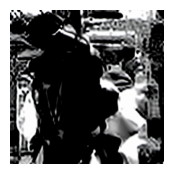

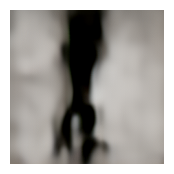

 68%|█████████████████████████▋            | 27/40 [05:14<02:32, 11.69s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a picture of a person.']


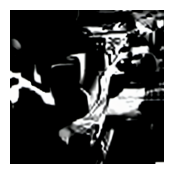

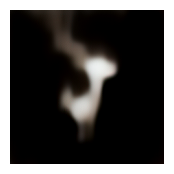

 70%|██████████████████████████▌           | 28/40 [05:25<02:18, 11.56s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person is standing up.']


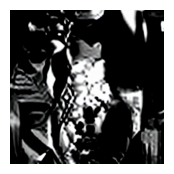

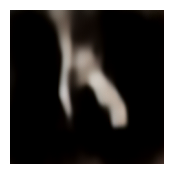

 72%|███████████████████████████▌          | 29/40 [05:37<02:06, 11.46s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person is holding a piece of paper.']


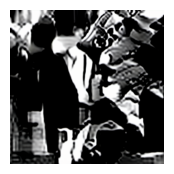

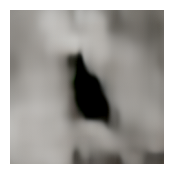

 75%|████████████████████████████▌         | 30/40 [05:49<01:56, 11.61s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person that is standing up.']


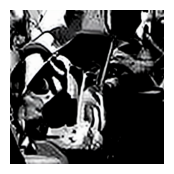

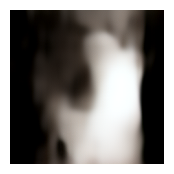

 78%|█████████████████████████████▍        | 31/40 [06:00<01:44, 11.58s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a picture of a person.']


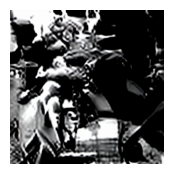

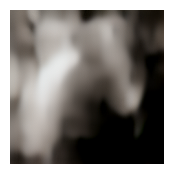

 80%|██████████████████████████████▍       | 32/40 [06:11<01:31, 11.48s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a person is standing in front of a camera.']


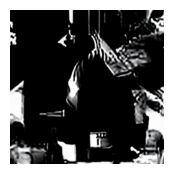

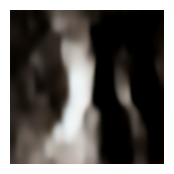

 82%|███████████████████████████████▎      | 33/40 [06:24<01:21, 11.70s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a large white and black object.']


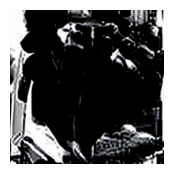

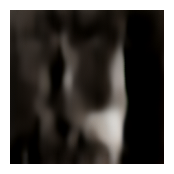

 85%|████████████████████████████████▎     | 34/40 [06:35<01:09, 11.63s/it]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

 85%|████████████████████████████████▎     | 34/40 [06:36<01:10, 11.67s/it]


KeyboardInterrupt: 

In [12]:
# get all reconstructions
model.to(cfg["device"])
model.eval().requires_grad_(False)

# all_images = None
all_blurryrecons = None
all_recons = None
all_predcaptions = []
all_clipvoxels = None

minibatch_size = 1
num_samples_per_image = 1
assert num_samples_per_image == 1

if utils.is_interactive(): plotting=True

with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
    for start_idx in tqdm(range(0,len(images),minibatch_size)):
        uniq_imgs = images[start_idx:start_idx + minibatch_size]
        voxel = voxels['subj06'][start_idx:start_idx + minibatch_size].unsqueeze(1).to(cfg["device"])

        voxel_ridge = model.ridge(voxel, 0) # 0th index of subj_list
        torch.cuda.empty_cache()
        backbone, clip_voxels, blurry_image_enc = model.backbone(voxel_ridge)
        blurry_image_enc = blurry_image_enc[0]
                
        # Save retrieval submodule outputs
        if all_clipvoxels is None:
            all_clipvoxels = clip_voxels.cpu()
        else:
            all_clipvoxels = torch.vstack((all_clipvoxels, clip_voxels.cpu()))
        
        # Feed voxels through OpenCLIP-bigG diffusion prior
        prior_out = model.diffusion_prior.p_sample_loop(backbone.shape, 
                        text_cond = dict(text_embed = backbone), 
                        cond_scale = 1., timesteps = 20)
        
        pred_caption_emb = clip_convert(prior_out.to(clip_convert.linear1.weight.device, clip_convert.linear1.weight.dtype))
        generated_ids = clip_text_model.generate(pixel_values=pred_caption_emb, max_length=20)
        generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)
        all_predcaptions = np.hstack((all_predcaptions, generated_caption))
        print(generated_caption)
        
        # Feed diffusion prior outputs through unCLIP
        for i in range(len(voxel)):
            samples = utils.unclip_recon(prior_out[[i]],
                             diffusion_engine,
                             vector_suffix,
                             num_samples=num_samples_per_image)
            if all_recons is None:
                all_recons = samples.cpu()
            else:
                all_recons = torch.vstack((all_recons, samples.cpu()))
            if plotting:
                for s in range(num_samples_per_image):
                    plt.figure(figsize=(2,2))
                    plt.imshow(transforms.ToPILImage()(samples[s]))
                    plt.axis('off')
                    plt.show()

        if cfg["model"]["blurry_recon"]:
            blurred_image = (autoenc.decode(blurry_image_enc/0.18215).sample/ 2 + 0.5).clamp(0,1)
            
            for i in range(len(voxel)):
                im = torch.Tensor(blurred_image[i])
                if all_blurryrecons is None:
                    all_blurryrecons = im[None].cpu()
                else:
                    all_blurryrecons = torch.vstack((all_blurryrecons, im[None].cpu()))
                if plotting:
                    plt.figure(figsize=(2,2))
                    plt.imshow(transforms.ToPILImage()(im))
                    plt.axis('off')
                    plt.show()

# resize outputs before saving
imsize = 256
all_recons = transforms.Resize((imsize,imsize))(all_recons).float()
if cfg["model"]["blurry_recon"]: 
    all_blurryrecons = transforms.Resize((imsize,imsize))(all_blurryrecons).float()
 
# # saving
# print(all_recons.shape)
# # # You can find the all_images file on huggingface: https://huggingface.co/datasets/pscotti/mindeyev2/tree/main/evals
# torch.save(images,f"{cfg['model']['evals_dir']}/all_images.pt")
# torch.save(voxels,f"{cfg['model']['evals_dir']}/all_voxels.pt") 
# if cfg["model"]["blurry_recon"]:
#     torch.save(all_blurryrecons, f"{cfg['model']['evals_dir']}/{cfg['model']['model_name']}_all_blurryrecons.pt")
# torch.save(all_recons,f"{cfg['model']['evals_dir']}/{cfg['model']['model_name']}_all_recons.pt")
# torch.save(all_predcaptions,f"{cfg['model']['evals_dir']}/{cfg['model']['model_name']}_all_predcaptions.pt")
# torch.save(all_clipvoxels,f"{cfg['model']['evals_dir']}/{cfg['model']['model_name']}_all_clipvoxels.pt")
# torch.save(cfg, f"{cfg['model']['evals_dir']}/cfg.pt")
# print(f"saved {cfg['model']['model_name']} outputs!")

# if not utils.is_interactive():
#     sys.exit(0)